# MACHINE LEARNING IN PRODUCTION MADRID - MLFLOW APPROACH

In previous lessons we've seen the feature engineering process of our dataset and we tried out the HDBSCAN algorithm for clustering. In this notebook we'll just focus on the training part (clusterization) using a KMeans algorithm from Scikit-Learn for the sake of simplicity.

We'll compare the traditional Machine Learning training approach with the new MLFlow paradigma. In order to focus just on training we'll load the embedding that comes from the UMAP projection (checkpoint in previous lesson).

## Traditional approach

### ETL

In [1]:
import pandas as pd

df = pd.read_parquet('../data/processed/embedding.parquet')

df.head()

,x,y
0,-10.861848,-3.012388
1,-4.257995,12.055279
2,-0.342640,-5.833466
3,13.796990,4.023094
4,-1.528758,-10.270776


### Clustering

In [2]:
import numpy as np
from sklearn.cluster import KMeans
    
# parameters for KMeans
n_clusters = 11
algorithm = 'elkan'
tol=1e-3

kmeans_m = KMeans(n_clusters=n_clusters,
                  algorithm=algorithm,
                  tol=1e-3,
                  random_state=42,
                  precompute_distances=True, 
                  n_jobs=-1)

clustering = kmeans_m.fit_predict(df)

print(f'Cluster Ids: {np.sort(np.unique(clustering))}')

Cluster Ids: [ 0  1  2  3  4  5  6  7  8  9 10]


### Metrics

In order to evaluate how good or bad is our model we'll use the silhouette score and the inertia.

In [3]:
from sklearn.metrics import silhouette_score

silhouette = silhouette_score(df, clustering)
print(f'Silhouette Score: {silhouette}')

inertia = kmeans_m.inertia_
print(f'Inertia: {inertia}')

Silhouette Score: 0.5273987054824829
Inertia: 41144.08885054348


It is also useful to save the clustering plot to check how it is related with the clustering metrics

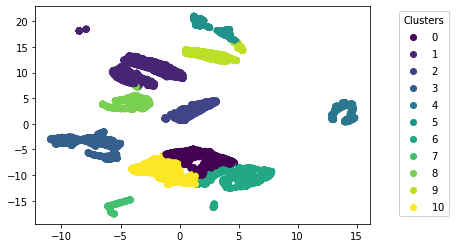

In [4]:
import matplotlib.pyplot as plt

%matplotlib inline

fig, ax = plt.subplots()

scatter = ax.scatter(x=df['x'], 
                     y=df['y'], 
                     c=clustering)
legend = ax.legend(*scatter.legend_elements(num=n_clusters - 1), 
                   title='Clusters', 
                   loc='upper right', 
                   bbox_to_anchor=(1.25,1.0))
ax.add_artist(legend);

output_folder = '../output/figures'

!if [ ! -d $output_folder ]; then mkdir -p $output_folder; fi

figure_path = f'{output_folder}/{n_clusters}_{algorithm}_{tol}.png'
plt.show()
plt.savefig(figure_path)
plt.close()

## MLFlow approach

Now is the time of seeing how this model would be trained using the MLFlow API and the benefits of doing it this way over the traditional approach

### ETL

In order to clean the code a little bit most of the imports have been defined here

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

%matplotlib inline

In [6]:
df = pd.read_parquet('../data/processed/embedding.parquet')

df.head()

,x,y
0,-10.861848,-3.012388
1,-4.257995,12.055279
2,-0.342640,-5.833466
3,13.796990,4.023094
4,-1.528758,-10.270776


### MLFlow Setup

The first step is to create an MLFlow experiment, so that all runs of our training process could be well organized.

In [7]:
import mlflow

mlflow.set_experiment('mlinproduction_training')

### MLFlow Train

Then, the following step would be creating a run for the experiment so that all the training process could be monitored and logged. This can be done just with the mlflow.start_run() sentence. The rest of API calls are explained with comments over the next cell.

/home/gurus/miniconda3/envs/mlinproduction_env/lib/python3.7/site-packages/py4j/java_collections.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import (
/home/gurus/miniconda3/envs/mlinproduction_env/lib/python3.7/site-packages/pyspark/resultiterable.py:23: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  class ResultIterable(collections.Iterable):


Silhouette Score: 0.5273987054824829
Inertia: 41144.08885054348


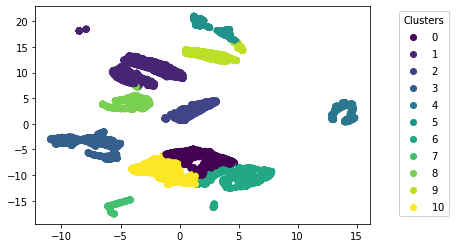

/home/gurus/miniconda3/envs/mlinproduction_env/lib/python3.7/site-packages/yaml/constructor.py:126: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if not isinstance(key, collections.Hashable):


In [8]:
import mlflow.sklearn

# starts run and closes it after all code has been executed
with mlflow.start_run():
    
    # parameters for KMeans
    n_clusters = 11
    algorithm = 'elkan'
    tol=1e-3

    # training
    kmeans_m = KMeans(n_clusters=n_clusters,
                      algorithm=algorithm,
                      tol=1e-3,
                      random_state=42,
                      precompute_distances=True, 
                      n_jobs=-1)
    clustering = kmeans_m.fit_predict(df)

    # metrics
    silhouette = silhouette_score(df, clustering)
    print(f'Silhouette Score: {silhouette}')

    inertia = kmeans_m.inertia_
    print(f'Inertia: {inertia}')
    
    fig, ax = plt.subplots()

    scatter = ax.scatter(x=df['x'], 
                         y=df['y'], 
                         c=clustering)
    legend = ax.legend(*scatter.legend_elements(num=n_clusters - 1), 
                       title='Clusters', 
                       loc='upper right', 
                       bbox_to_anchor=(1.25,1.0))
    ax.add_artist(legend);
    
    output_folder = '../output/figures'

    !if [ ! -d $output_folder ]; then mkdir -p $output_folder; fi

    figure_path = f'{output_folder}/{n_clusters}_{algorithm}_{tol}.png'
    plt.show()
    plt.savefig(figure_path)
    plt.close()

    # here starts the MLFlow monitoring
    
    # first the model hyperparameters are logged to the tracking server
    mlflow.log_param('n_clusters', n_clusters)
    mlflow.log_param('algorithm', algorithm)
    mlflow.log_param('tol', tol)
    
    # then the metrics resulting from the training process
    mlflow.log_metric('silhouette', silhouette)
    mlflow.log_metric('inertia', inertia)

    # the figure with the clustering plot can also be logged
    mlflow.log_artifact(figure_path, 'figures')
    
    # finally the model is logged
    mlflow.sklearn.log_model(kmeans_m, 'model')
    

### MLFlow Train Several Times

The training process used to be performed manually in the traditional way, changing cells in the Jupyter Notebook and waiting for the results, trying to get the configuration that suits the best to the model performance. With MLFlow you can just run again and again with the confidence of being logging everything and recover that configuration that once worked amazing.

So in order to organize the code a little bit, a train function has been defined.

In [9]:
def train(n_clusters, algorithm, tol):
    
    # training
    kmeans_m = KMeans(n_clusters=n_clusters,
                      algorithm=algorithm,
                      tol=1e-3,
                      random_state=42,
                      precompute_distances=True, 
                      n_jobs=-1)
    clustering = kmeans_m.fit_predict(df)

    # metrics
    silhouette = silhouette_score(df, clustering)
    print(f'Silhouette Score: {silhouette}')

    inertia = kmeans_m.inertia_
    print(f'Inertia: {inertia}')
    
    fig, ax = plt.subplots()

    scatter = ax.scatter(x=df['x'], 
                         y=df['y'], 
                         c=clustering)
    legend = ax.legend(*scatter.legend_elements(num=n_clusters - 1), 
                       title='Clusters', 
                       loc='upper right', 
                       bbox_to_anchor=(1.25,1.0))
    ax.add_artist(legend);
    
    output_folder = '../output/figures'

    !if [ ! -d $output_folder ]; then mkdir -p $output_folder; fi

    figure_path = f'{output_folder}/{n_clusters}_{algorithm}_{tol}.png'
    plt.show()
    plt.savefig(figure_path)
    plt.close()

    # here starts the MLFlow monitoring
    
    # first the model hyperparameters are logged to the tracking server
    mlflow.log_param('n_clusters', n_clusters)
    mlflow.log_param('algorithm', algorithm)
    mlflow.log_param('tol', tol)
    
    # then the metrics resulting from the training process
    mlflow.log_metric('silhouette', silhouette)
    mlflow.log_metric('inertia', inertia)

    # the figure with the clustering plot can also be logged
    mlflow.log_artifact(figure_path, 'figures')
    
    # finally the model is logged
    mlflow.sklearn.log_model(kmeans_m, 'model')

Then we can try out the training process with different parameters in a loop.


Training KMeans for 5 clusters, full algorithm and tol 0.1...
                
Silhouette Score: 0.5125728845596313
Inertia: 147689.13674251837


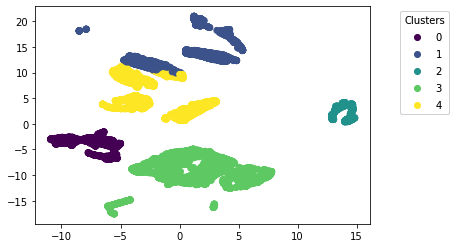


Training KMeans for 5 clusters, full algorithm and tol 0.001...
                
Silhouette Score: 0.5125728845596313
Inertia: 147689.13674251837


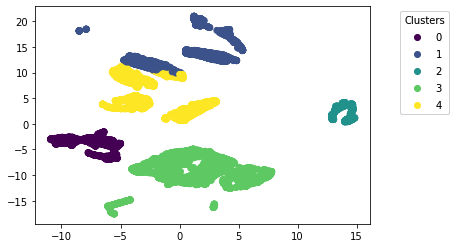


Training KMeans for 5 clusters, elkan algorithm and tol 0.1...
                
Silhouette Score: 0.5125728845596313
Inertia: 147689.13674251837


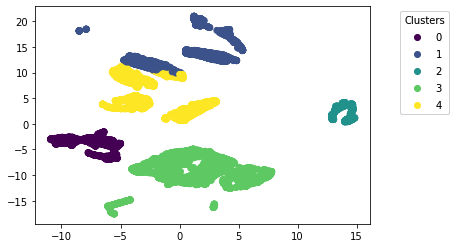


Training KMeans for 5 clusters, elkan algorithm and tol 0.001...
                
Silhouette Score: 0.5125728845596313
Inertia: 147689.13674251837


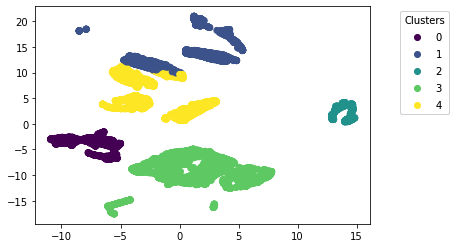


Training KMeans for 11 clusters, full algorithm and tol 0.1...
                
Silhouette Score: 0.5273275375366211
Inertia: 41150.67996349352


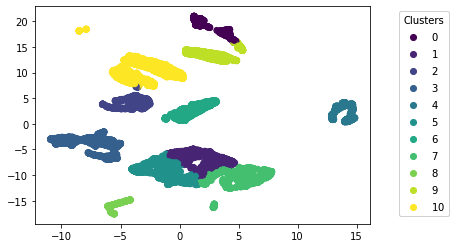


Training KMeans for 11 clusters, full algorithm and tol 0.001...
                
Silhouette Score: 0.5273275375366211
Inertia: 41150.67996349352


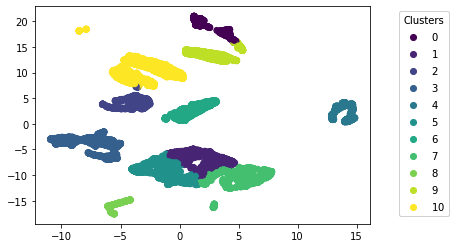


Training KMeans for 11 clusters, elkan algorithm and tol 0.1...
                
Silhouette Score: 0.5273987054824829
Inertia: 41144.08885054348


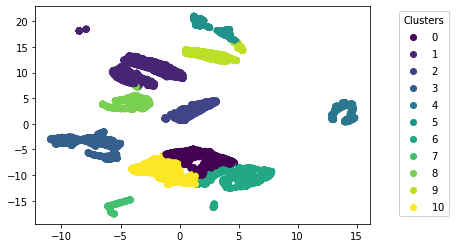


Training KMeans for 11 clusters, elkan algorithm and tol 0.001...
                
Silhouette Score: 0.5273987054824829
Inertia: 41144.08885054348


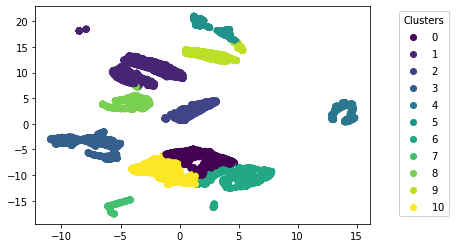

In [10]:
# hyperparameter options
n_clusters_list = [5, 11]
algorithm_list = ['full', 'elkan']
tol_list = [1e-1, 1e-3]
    
for n_clusters in n_clusters_list:
    for algorithm in algorithm_list:
        for tol in tol_list:
            with mlflow.start_run():
                logging_message = f"""
Training KMeans for {n_clusters} clusters, {algorithm} algorithm and tol {tol}...
                """
                print(logging_message)
                train(n_clusters, algorithm, tol)
    

Now it could be interesting to recover the results of an execution we want to explore and maybe load the model to do some predictions.

### Model Loading

#### MLFlow Load

First, let's recover all runs that we've just done.

In [11]:
mlflow.search_runs()

,run_id,experiment_id,status,artifact_uri,metrics.silhouette,metrics.inertia,params.n_clusters,params.algorithm,params.tol,tags.mlflow.source.name,tags.mlflow.source.type,tags.mlflow.user
0,d27b7ffc73824a65b2db41185c6bf5a9,1,FINISHED,file:/home/gurus/mlruns/1/d27b7ffc73824a65b2db...,0.527399,41144.088851,11,elkan,0.001,/home/gurus/miniconda3/envs/mlinproduction_env...,LOCAL,gurus
1,7ebc7a57f4db4cc88a59fedd5a1b805c,1,FINISHED,file:/home/gurus/mlruns/1/7ebc7a57f4db4cc88a59...,0.527399,41144.088851,11,elkan,0.1,/home/gurus/miniconda3/envs/mlinproduction_env...,LOCAL,gurus
2,520430fc6f2e492ea65e6c7946092211,1,FINISHED,file:/home/gurus/mlruns/1/520430fc6f2e492ea65e...,0.527328,41150.679963,11,full,0.001,/home/gurus/miniconda3/envs/mlinproduction_env...,LOCAL,gurus
3,5c0216fb449a400ba18b34cc6014c9d6,1,FINISHED,file:/home/gurus/mlruns/1/5c0216fb449a400ba18b...,0.527328,41150.679963,11,full,0.1,/home/gurus/miniconda3/envs/mlinproduction_env...,LOCAL,gurus
4,7797bfcd5e8d4c39949a4527696d1fbb,1,FINISHED,file:/home/gurus/mlruns/1/7797bfcd5e8d4c39949a...,0.512573,147689.136743,5,elkan,0.001,/home/gurus/miniconda3/envs/mlinproduction_env...,LOCAL,gurus
...,...,...,...,...,...,...,...,...,...,...,...,...
84,2a6c0302efb845caa9391b1da5e58cbb,1,FINISHED,file:/home/gurus/mlruns/1/2a6c0302efb845caa939...,0.456935,332475.158031,3,elkan,1e-05,/home/gurus/miniconda3/envs/mlinproduction_env...,LOCAL,gurus
85,4637687715d0450d97bcc7215c29d84a,1,FINISHED,file:/home/gurus/mlruns/1/4637687715d0450d97bc...,0.456935,332475.158031,3,elkan,0.001,/home/gurus/miniconda3/envs/mlinproduction_env...,LOCAL,gurus
86,2bcebb15974c4b50a3805108a800abd4,1,FINISHED,file:/home/gurus/mlruns/1/2bcebb15974c4b50a380...,0.456935,332475.158031,3,elkan,0.1,/home/gurus/miniconda3/envs/mlinproduction_env...,LOCAL,gurus
87,ea3edc49050543f89c9642efb56835c3,1,FINISHED,file:/home/gurus/mlruns/1/ea3edc49050543f89c96...,0.527399,41144.088851,11,elkan,0.001,/home/gurus/miniconda3/envs/mlinproduction_env...,LOCAL,gurus


Let's then load the last model we've run.

In [12]:
last_run = mlflow.search_runs(max_results=1).loc[0]

model = mlflow.sklearn.load_model(f'runs:/{last_run["run_id"]}/model')
print(model)
                                  
print(f'Inertia: {model.inertia_}')

KMeans(algorithm='elkan', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=11, n_init=10, n_jobs=-1, precompute_distances=True,
       random_state=42, tol=0.001, verbose=0)
Inertia: 41144.08885054348


We've loaded the trained model in just one line, specifying the run id to MLFLow.

#### Pickle Load

As expected, we can also load the model in the old way (load from pickle) from the folder where we specified to MLFlow to log the model.

In [13]:
path = f'{last_run["artifact_uri"]}/model'.replace('file:', '')

!ls -al $path

total 56
drwxrwxr-x 2 gurus gurus  4096 Sep 26 17:12 .
drwxrwxr-x 4 gurus gurus  4096 Sep 26 17:12 ..
-rw-rw-r-- 1 gurus gurus   343 Sep 26 17:12 MLmodel
-rw-rw-r-- 1 gurus gurus   130 Sep 26 17:12 conda.yaml
-rw-rw-r-- 1 gurus gurus 40760 Sep 26 17:12 model.pkl


In [14]:
import pickle

with open(f'{path}/model.pkl', 'rb') as f:
    model_pkl = pickle.load(f)

print(model_pkl)                   
print(f'Inertia: {model.inertia_}')

KMeans(algorithm='elkan', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=11, n_init=10, n_jobs=-1, precompute_distances=True,
       random_state=42, tol=0.001, verbose=0)
Inertia: 41144.08885054348


### Predictions

All training would not have sense without the ability of making predictions on new data. The following cell checks that the model behaves as expected with some test data.

In [15]:
test_data = df.head()

# if the last MLFlow run is selected the model should have the same 
# parameters as the first example so the clustering variable should
# contain the actual results of the model
actual_data = clustering[:5]

predictions = model.predict(test_data)
print(f'Predictions: {predictions}')

performance = predictions == actual_data
print(f'Performance: {performance}')

Predictions: [ 3  1  0  4 10]
Performance: [ True  True  True  True  True]


### Prototype to Production

All Data Scientists dream about having their model one day in production. This is freaking simple with MLFlow. It sets up an HTTP endpoint where you can send the data you want to predict and then it can send you back a response from your model.

However you should run on your server the following line in order to setup the endpoint:

```
mlflow models serve -m path_to_your_model -h host -p port
```

It is also necessary to convert the data into a suitable HTTP post body.

In [16]:
http_data = test_data.to_json(orient='split')

http_data

'{"columns":["x","y"],"index":[0,1,2,3,4],"data":[[-10.8618478775,-3.0123884678],[-4.2579946518,12.0552787781],[-0.3426400125,-5.833466053],[13.7969903946,4.0230937004],[-1.5287576914,-10.270775795]]}'

#### requests approach

```python
import requests

host = 'host'
port = 'port'

url = f'http://{host}:{port}/invocations'
    
headers = {
    'Content-Type': 'application/json',
}

r = requests.post(url=url, headers=headers, data=http_data)

predictions = [int(x) for x in r.text if x.isdigit()]
print(f'Predictions: {predictions}')

performance = predictions == actual_data
print(f'Performance: {performance}')
```

#### cURL approach

```
curl http://host:port/invocations -H 'Content-Type: application/json' -d http_data
```